# Wind Speed plotted over Orography Data 
trying to visualize wind speed over orography. Needed to simplify my other notebook so it would run faster and become less overwhleming.

In [3]:
##importing all the packages needed to run code.
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
import numpy as np
import xarray as xr ## xarray to make most of the plots
%matplotlib inline
%config InlineBackend.figure_format='retina'
import cmocean ## for colors on plots
import cartopy.crs as ccrs
import matplotlib.path as mpath
import nc_time_axis
import pandas as pd
import zarr ## for google cloud load in
import gcsfs

In [4]:
##importing south polar projection. ## This function was provided by Dr. Beadling in Climate Modeling course.
def South_Polar(array,vmin,vmax,cmap):
    subplot_kws = dict(projection=ccrs.SouthPolarStereo()) 
    fig, ax = plt.subplots(figsize=[10, 5],subplot_kw=subplot_kws)
    
    array.plot.contourf(ax=ax,
               transform =ccrs.PlateCarree(),
               vmin=vmin,
               vmax=vmax,
               extend='both',
               cmap=cmap, levels=45)

    # Limit the map to -50 degrees latitude and below.
    ax.set_extent([-180, 180, -90, -55], ccrs.PlateCarree())
    
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    ax.set_boundary(circle, transform=ax.transAxes)
    ax.coastlines()

In [5]:
##importing Eastward Near-Surface Wind data from google cloud. Amon
df_uas = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df_uas	
# step two … # replace with the id you need and other info to ween down datasets 
df_u = df_uas.query("source_id=='GFDL-CM4' & experiment_id == 'piControl' & variable_id == 'uas'& table_id == 'Amon'")
df_u
# step three - loading in the data and storing it
gcs = gcsfs.GCSFileSystem(token='anon')
zstore = df_u.zstore.values[-1]
mapper = gcs.get_mapper(zstore)
ds_uas = xr.open_zarr(mapper, consolidated=True)

In [6]:
## selecting the UAS variable and renaming it to Uas_winds.
## This allows us to look at the value we want for eastward wind.
Uas_winds = ds_uas.uas
## Slicing the eastward wind into the south pole region, as well as averaging the 500 year time values.
## This provides the average for 500 year. Can be named whatever I just named it this bc im cool.
Uas_151_650 = Uas_winds.sel(lat=slice(-89.5,-55)).sel(time=slice('0151-01-16','0650-12-16')).mean(dim='time')
Uas_151_650

<xarray.DataArray 'uas' (lat: 35, lon: 288)>
dask.array<mean_agg-aggregate, shape=(35, 288), dtype=float32, chunksize=(35, 288), chunktype=numpy.ndarray>
Coordinates:
    height   float64 ...
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 ... -58.5 -57.5 -56.5 -55.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4

In [7]:
##UAS wind dataset defined above
Uas_winds
## slicing the UAS into south polar lat
Antsliceuas = Uas_winds.sel(lat=slice(-89.5,-55))
Antsliceuas
## grouping the data into seasons and averaging the 500 seasons
uas_seasonal = Antsliceuas.groupby('time.season').mean(dim='time')
uas_seasonal
## creating seasonal variables
uas_summer = uas_seasonal.sel(season='DJF') ##southern hemisphere has summer in december,jan,feb
uas_winter = uas_seasonal.sel(season='JJA') ### winter months in southern hemisphere
uas_spring = uas_seasonal.sel(season='SON') ## spring months in southern hemisphere
uas_fall = uas_seasonal.sel(season='MAM') ## fall months in southern hemisphere

In [8]:
##importing Northward Near-Surface Wind data from google cloud.
df_vas = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df_vas	
# step two … # replace with the id you need and other info to ween down datasets 
df_v = df_vas.query("source_id=='GFDL-CM4' & experiment_id == 'piControl' & variable_id == 'vas'& table_id == 'Amon'")
df_v
# step three 
gcs = gcsfs.GCSFileSystem(token='anon')
zstore = df_v.zstore.values[-1]
mapper = gcs.get_mapper(zstore)
ds_vas = xr.open_zarr(mapper, consolidated=True)

In [9]:
## selecting the Vas variable and naming it to Vas_winds. allows us to look at northward winds.
Vas_winds = ds_vas.vas
## slicing Vas_winds to south polar region and averaging 500 year to get average.
Vas_151_650 = Vas_winds.sel(lat=slice(-89.5,-55)).sel(time=slice('0151-01-16','0650-12-16')).mean(dim='time')
Vas_151_650

<xarray.DataArray 'vas' (lat: 35, lon: 288)>
dask.array<mean_agg-aggregate, shape=(35, 288), dtype=float32, chunksize=(35, 288), chunktype=numpy.ndarray>
Coordinates:
    height   float64 ...
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 ... -58.5 -57.5 -56.5 -55.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4

In [10]:
## VAS data set as defined earlier
Vas_winds
## slicing vas into south pole lat
antslicevas = Vas_winds.sel(lat=slice(-89.5,-55))
## grouping Vas into seasons and averaging the 500 seasons.
vas_seasonal = antslicevas.groupby('time.season').mean(dim='time')
## plotting to see DJF / month values
vas_seasonal
## creating seasonal variables ## im not sure we need these actually...
vas_summer = vas_seasonal.sel(season='DJF') ##southern hemisphere has summer in december,jan,feb
vas_winter = vas_seasonal.sel(season='JJA') ### winter months in southern hemisphere
vas_spring = vas_seasonal.sel(season='SON') ## spring months in southern hemisphere
vas_fall = vas_seasonal.sel(season='MAM') ## fall months in southern hemisphere

In [11]:
## naming CM4 variables like you seen in other notebooks
Uas = ds_uas.uas
Vas = ds_vas.vas

In [12]:
## merge winds by merging eastward and northward.
mergewinds = xr.merge([Uas,Vas]) # merge winds to make it easy
xmerge = mergewinds.lon #extracting the lon component fomr the mergewinds array
ymerge = mergewinds.lat
umerge = mergewinds.uas 
vmerge = mergewinds.vas
speedmerge = np.sqrt(np.square(umerge) + np.square(vmerge)) ## calculating speed using vector sum formula
## average
timeaveragemerge = mergewinds.sel(time=slice('0151-01-16','0650-12-16')).mean(dim='time')
timeaveragemerge

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 288)
Coordinates:
    height   float64 10.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
Data variables:
    uas      (lat, lon) float32 dask.array<chunksize=(180, 288), meta=np.ndarray>
    vas      (lat, lon) float32 dask.array<chunksize=(180, 288), meta=np.ndarray>

In [13]:
### slicing the speed for the south pole
speedslice = speedmerge.sel(lat=slice(-89.5,-55)).sel(time=slice('0151-01-16','0650-12-16')).mean(dim='time')

In [14]:
## UAS seasonal dataset
uas_seasonal
## VAS seasonal plot
vas_seasonal
## merging the UAS seasonal and Vas seasonal to get merge seasonal
seasonalmerge = xr.merge([uas_seasonal,vas_seasonal])
seasonalmerge

<xarray.Dataset>
Dimensions:  (lat: 35, lon: 288, season: 4)
Coordinates:
    height   float64 10.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 ... -58.5 -57.5 -56.5 -55.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    uas      (season, lat, lon) float32 dask.array<chunksize=(1, 35, 288), meta=np.ndarray>
    vas      (season, lat, lon) float32 dask.array<chunksize=(1, 35, 288), meta=np.ndarray>
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order2
    long_name:      Eastward Near-Surface Wind
    original_name:  uas
    standard_name:  eastward_wind
    units:          m s-1

In [15]:
## calculating the seasonal wind speed
seasonalspeedmerge = np.sqrt(np.square(seasonalmerge.uas) + np.square(seasonalmerge.vas))
## slicing the summer speed
Summer_szn_speed = seasonalspeedmerge.sel(season=slice('DJF')).mean(dim='season')
## Slicing summer season from seasonalmerge
Summer_szn= seasonalmerge.sel(season='DJF')
## slicing seasonalspeed to get speed for winter and averaging it
Winter_szn_speed = seasonalspeedmerge.sel(season=slice('JJA')).mean(dim='season')
Winter_szn= seasonalmerge.sel(season='JJA')
## FALL seasonal speed merge and averaging
Fall_szn_speed = seasonalspeedmerge.sel(season=slice('MAM')).mean(dim='season')
Fall_szn= seasonalmerge.sel(season='MAM')
## slicing seasonalspeed to get spring values and averaging it
Spring_szn_speed = seasonalspeedmerge.sel(season=slice('SON')).mean(dim='season')
Spring_szn= seasonalmerge.sel(season='SON')

# <span style="color:red">ESM4 DATA</span>

In [16]:
google_cloud_cmip6 = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')

In [17]:
#defines the Eastward Near-Surface Wind
gfdl_esm4_uas_data = google_cloud_cmip6.query(
    "table_id == 'Amon' & \
    variable_id == 'uas' & \
    experiment_id == 'piControl' & \
    institution_id == 'NOAA-GFDL' &  \
    source_id == 'GFDL-ESM4'")

gcs = gcsfs.GCSFileSystem(token='anon')
zstore_esm4_uas = gfdl_esm4_uas_data.zstore.values[-1]
mapper_esm4_uas = gcs.get_mapper(zstore_esm4_uas)

esm4_uas = xr.open_zarr(mapper_esm4_uas, 
                                consolidated=True,use_cftime=True).uas.rename({'lat':'latitude',
                                                             'lon':'longitude'})

#defines the NorthWard Near-Surface Wind
gfdl_esm4_vas_data = google_cloud_cmip6.query(
    "table_id == 'Amon' & \
    variable_id == 'vas' & \
    experiment_id == 'piControl' & \
    institution_id == 'NOAA-GFDL' &  \
    source_id == 'GFDL-ESM4'")

zstore_esm4_vas = gfdl_esm4_vas_data.zstore.values[-1]
mapper_esm4_vas = gcs.get_mapper(zstore_esm4_vas)

esm4_vas = xr.open_zarr(mapper_esm4_vas, 
                                consolidated=True,use_cftime=True).vas.rename({'lat':'latitude',
                                                             'lon':'longitude'})

In [18]:
uase4=esm4_uas#.sel(time=slice('0001-01-16','0500-01-16')).mean(dim='time')#.groupby('time.season').mean(dim='time')
vase4 = esm4_vas#.sel(time=slice('0001-01-16','0500-01-16')).mean(dim='time')

In [19]:
## Slicing the eastward wind into the south pole region, as well as averaging the 500 year time values.
## This provides the average for 500 year. Can be named whatever I just named it this bc im cool.
uase4_500_avg=uase4.sel(latitude=slice(-89.5,-55)).sel(time=slice('0151-01-16','0650-12-16')).mean(dim='time')

In [20]:
uase4 #eastward wind variable
## slicing the uase4 into south polar lat
ESM4_Antsliceuas = uase4.sel(latitude=slice(-89.5,-55))
ESM4_Antsliceuas
## grouping the data into seasons and averaging the 500 seasons
ESM4_uas_seasonal = ESM4_Antsliceuas.groupby('time.season').mean(dim='time')
ESM4_uas_seasonal
## grouping into seasonal varibles 
ESM4_uas_summer = ESM4_uas_seasonal.sel(season='DJF') ##southern hemisphere has summer in december,jan,feb
ESM4_uas_winter = ESM4_uas_seasonal.sel(season='JJA') ### winter months in southern hemisphere
ESM4_uas_spring = ESM4_uas_seasonal.sel(season='SON') ## spring months in southern hemisphere
ESM4_uas_fall = ESM4_uas_seasonal.sel(season='MAM') ## fall months in southern hemisphere

In [21]:
## Slicing the eastward wind into the south pole region, as well as averaging the 500 year time values.
## This provides the average for 500 year. Can be named whatever I just named it this bc im cool.
vase4_500_avg=vase4.sel(latitude=slice(-89.5,-55)).sel(time=slice('0151-01-16','0650-12-16')).mean(dim='time')

In [22]:
vase4 #northward wind variable
## slicing the vase4 into south polar lat
ESM4_Antslicevas = vase4.sel(latitude=slice(-89.5,-55))
ESM4_Antslicevas
## grouping the data into seasons and averaging the 500 seasons
ESM4_vas_seasonal = ESM4_Antslicevas.groupby('time.season').mean(dim='time')
ESM4_vas_seasonal
## creating seasonal variables 
ESM4_vas_summer = ESM4_vas_seasonal.sel(season='DJF') ##southern hemisphere has summer in december,jan,feb
ESM4_vas_winter = ESM4_vas_seasonal.sel(season='JJA') ### winter months in southern hemisphere
ESM4_vas_spring = ESM4_vas_seasonal.sel(season='SON') ## spring months in southern hemisphere
ESM4_vas_fall = ESM4_vas_seasonal.sel(season='MAM') ## fall months in southern hemisphere

In [23]:
uase4=esm4_uas#.sel(time=slice('0001-01-16','0500-01-16')).mean(dim='time')#.groupby('time.season').mean(dim='time')
vase4 = esm4_vas#.sel(time=slice('0001-01-16','0500-01-16')).mean(dim='time')
mergedwindse4 = xr.merge([uase4,vase4])
esm4_xmerge=mergedwindse4.longitude
esm4_ymerge=mergedwindse4.latitude
esm4_umerge=mergedwindse4.uas
esm4_vmerge=mergedwindse4.vas
esm4_speed_merge=np.sqrt(np.square(esm4_umerge) + np.square(esm4_vmerge)).sel(latitude=slice(-90,-55))
esm4_speed_merge
#wind speed around antarctica 
#####
esm4_timeaveragemerge = mergedwindse4.sel(time=slice('0001-01-16','0500-01-16')).mean(dim='time')
esm4_timeaveragemerge

<xarray.Dataset>
Dimensions:    (latitude: 180, longitude: 288)
Coordinates:
    height     float64 10.0
  * latitude   (latitude) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * longitude  (longitude) float64 0.625 1.875 3.125 4.375 ... 356.9 358.1 359.4
Data variables:
    uas        (latitude, longitude) float32 dask.array<chunksize=(180, 288), meta=np.ndarray>
    vas        (latitude, longitude) float32 dask.array<chunksize=(180, 288), meta=np.ndarray>

In [24]:
### slicing the speed for the south pole
ESM4_speedslice = esm4_speed_merge.sel(latitude=slice(-89.5,-55)).sel(time=slice('0151-01-16','0650-12-16')).mean(dim='time')
ESM4_speedslice

<xarray.DataArray (latitude: 35, longitude: 288)>
dask.array<mean_agg-aggregate, shape=(35, 288), dtype=float32, chunksize=(35, 288), chunktype=numpy.ndarray>
Coordinates:
    height     float64 10.0
  * latitude   (latitude) float64 -89.5 -88.5 -87.5 -86.5 ... -57.5 -56.5 -55.5
  * longitude  (longitude) float64 0.625 1.875 3.125 4.375 ... 356.9 358.1 359.4

# Orogrpahy Data (SURFACE ALTITUDE)
attempting to plot quivers on orography data

# <span style="color:red">LOADING IN ORGOGAPHY DATA</span>

In [25]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')

In [26]:
df_orog_cm4 = df.query("source_id=='GFDL-CM4' & experiment_id == 'piControl' & variable_id == 'orog' & grid_label=='gr1'")
df_orog_cm4

gcs = gcsfs.GCSFileSystem(token='anon')
zstore = df_orog_cm4.zstore.values[-1]
mapper = gcs.get_mapper(zstore)

orog_cm4 = xr.open_zarr(mapper, consolidated=True)
orog_cm4

df_orog_esm4 = df.query("source_id=='GFDL-ESM4' & experiment_id == 'piControl' & variable_id == 'orog' & grid_label=='gr1'")
df_orog_esm4

gcs = gcsfs.GCSFileSystem(token='anon')
zstore = df_orog_esm4.zstore.values[-1]
mapper = gcs.get_mapper(zstore)

orog_esm4 = xr.open_zarr(mapper, consolidated=True)
orog_esm4

<xarray.Dataset>
Dimensions:   (bnds: 2, lat: 180, lon: 288)
Coordinates:
  * bnds      (bnds) float64 1.0 2.0
  * lat       (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
    lat_bnds  (lat, bnds) float64 dask.array<chunksize=(180, 2), meta=np.ndarray>
  * lon       (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
    lon_bnds  (lon, bnds) float64 dask.array<chunksize=(288, 2), meta=np.ndarray>
Data variables:
    orog      (lat, lon) float32 dask.array<chunksize=(180, 288), meta=np.ndarray>
Attributes: (12/49)
    Conventions:            CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:            CMIP
    branch_method:          Coupled climate state after 400 years of spinup, ...
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    comment:                <null ref>
    ...                     ...
    tracking_id:            hdl:21.14100/e0d39952-a008-419b-8454-d44d8e138fec
    variable_id:            orog
    variant_info:           N/A
    variant_label:          r1i1p1f1
    netcdf_tracking_ids:    hdl:21.14100/e0d39952-a008-419b-8454-d44d8e138fec
    version_id:             v20180701

In [27]:
#VARIABLES
CM4_orog = orog_cm4.orog
ESM4_orog = orog_esm4.orog

# <span style="color:red">CM4 DATA</span>

In [28]:
#slicing to get orography just in the south pole region
CM4_orog_antslice=CM4_orog.sel(lat=slice(-89.5,-55))
CM4_orog_antslice

<xarray.DataArray 'orog' (lat: 35, lon: 288)>
dask.array<getitem, shape=(35, 288), dtype=float32, chunksize=(35, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 ... -58.5 -57.5 -56.5 -55.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: mean
    interp_method:  conserve_order1
    long_name:      Surface Altitude
    original_name:  orog
    standard_name:  surface_altitude
    units:          m

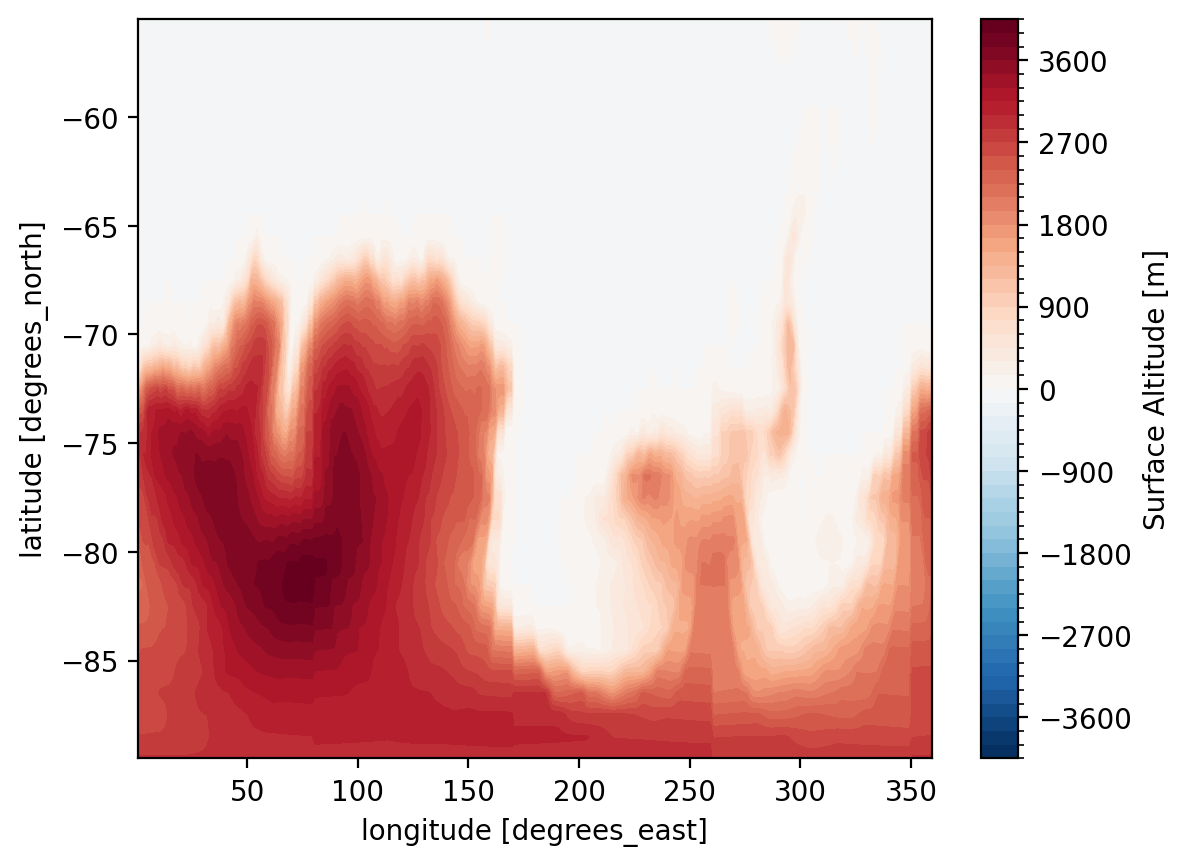

In [29]:
CM4_orog_antslice.plot.contourf(levels=60) #doing this to see the scale

Text(0.5, 1.0, 'CM4 Orography')

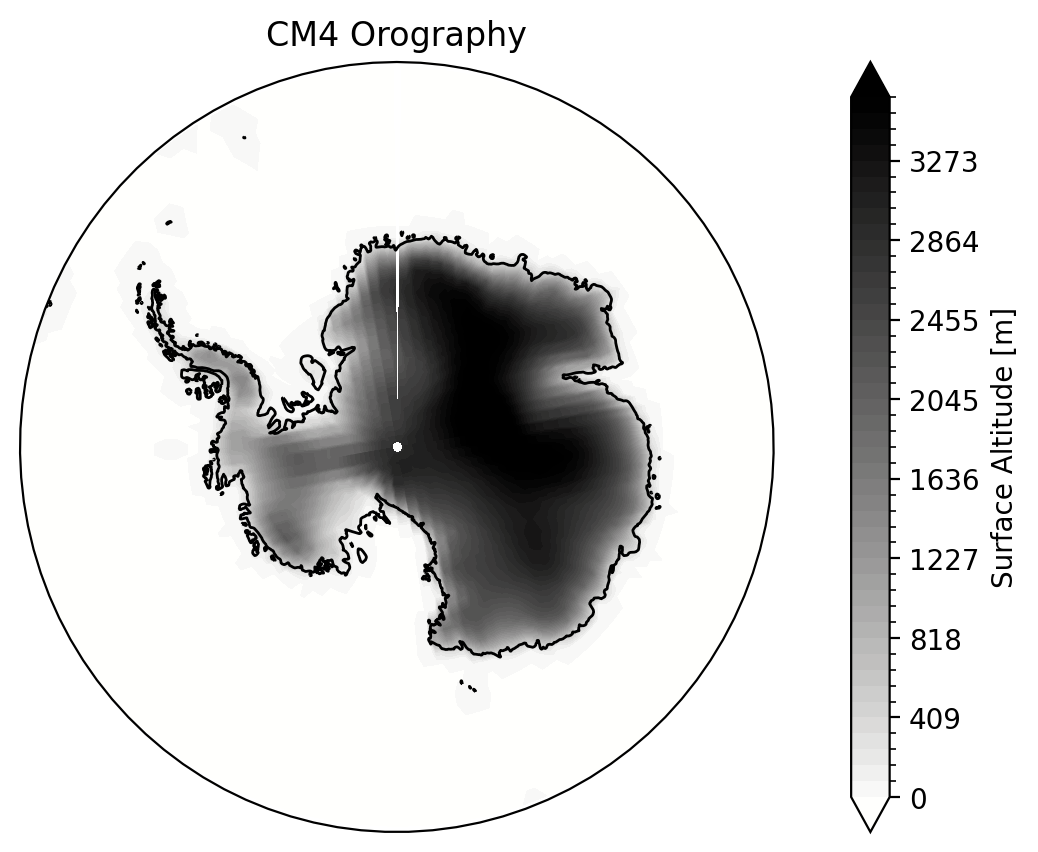

In [30]:
## plotting south pole orography on the south polar function to make a nice beautiful plot
South_Polar(CM4_orog_antslice,0,3600,cmap=cmocean.cm.gray_r)
## this plots a title on the top of the graph
plt.title("CM4 Orography")
#not sure what the best color schme is for this tbh

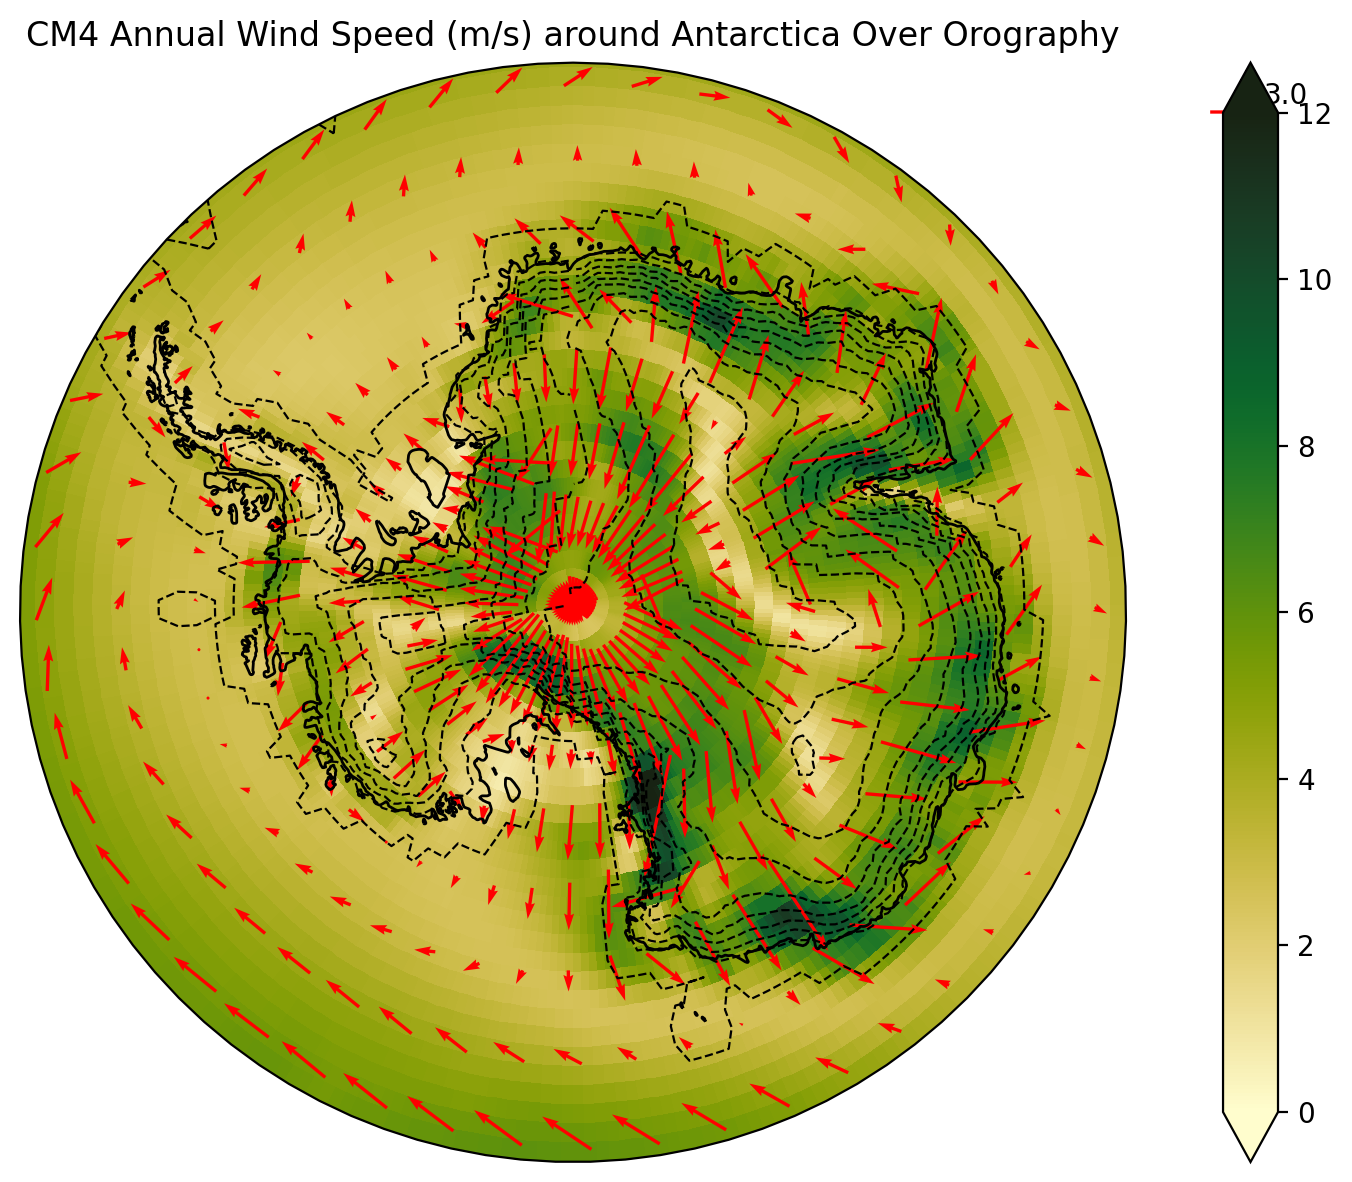

In [31]:
subplot_kws = dict(projection=ccrs.SouthPolarStereo())
fig, ax = plt.subplots(figsize=[10, 6],subplot_kw=subplot_kws)
speedslice.plot(ax=ax,
               transform =ccrs.PlateCarree(),
               vmin=0,
               vmax=12,
               extend='both',
               cmap=cmocean.cm.speed)
CM4_orog_antslice.plot.contour(ax=ax,
               transform =ccrs.PlateCarree(),
               vmin=0,
               vmax=3600,
               extend='both',
               colors='k', levels=10, linewidths=0.8,linestyles='--')
    # Limit the map to -50 degrees latitude and below.
ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
ax.coastlines()

q=timeaveragemerge.isel(lon=slice(None, None, 6),lat=slice(0, 36, 4)).plot.quiver(x='lon',
                                       y='lat',
                                       u='uas',
                                       v='vas',
                                       width=0.003,
                                       scale=98, color='red',transform =ccrs.PlateCarree())

ax.quiverkey(q, X=1, Y=1, U=1,
             label='E',coordinates='figure')
plt.title('CM4 Annual Wind Speed (m/s) around Antarctica Over Orography')
plt.tight_layout()

# <span style="color:red">ESM4 DATA</span>

In [32]:
#slicing to get orography just in the south pole region
ESM4_orog_antslice=ESM4_orog.sel(lat=slice(-89.5,-55))
ESM4_orog_antslice

<xarray.DataArray 'orog' (lat: 35, lon: 288)>
dask.array<getitem, shape=(35, 288), dtype=float32, chunksize=(35, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 ... -58.5 -57.5 -56.5 -55.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: mean
    interp_method:  conserve_order1
    long_name:      Surface Altitude
    original_name:  orog
    standard_name:  surface_altitude
    units:          m

Text(0.5, 1.0, 'ESM4 Annual Wind Speed (m/s) around Antarctica Over Orography')

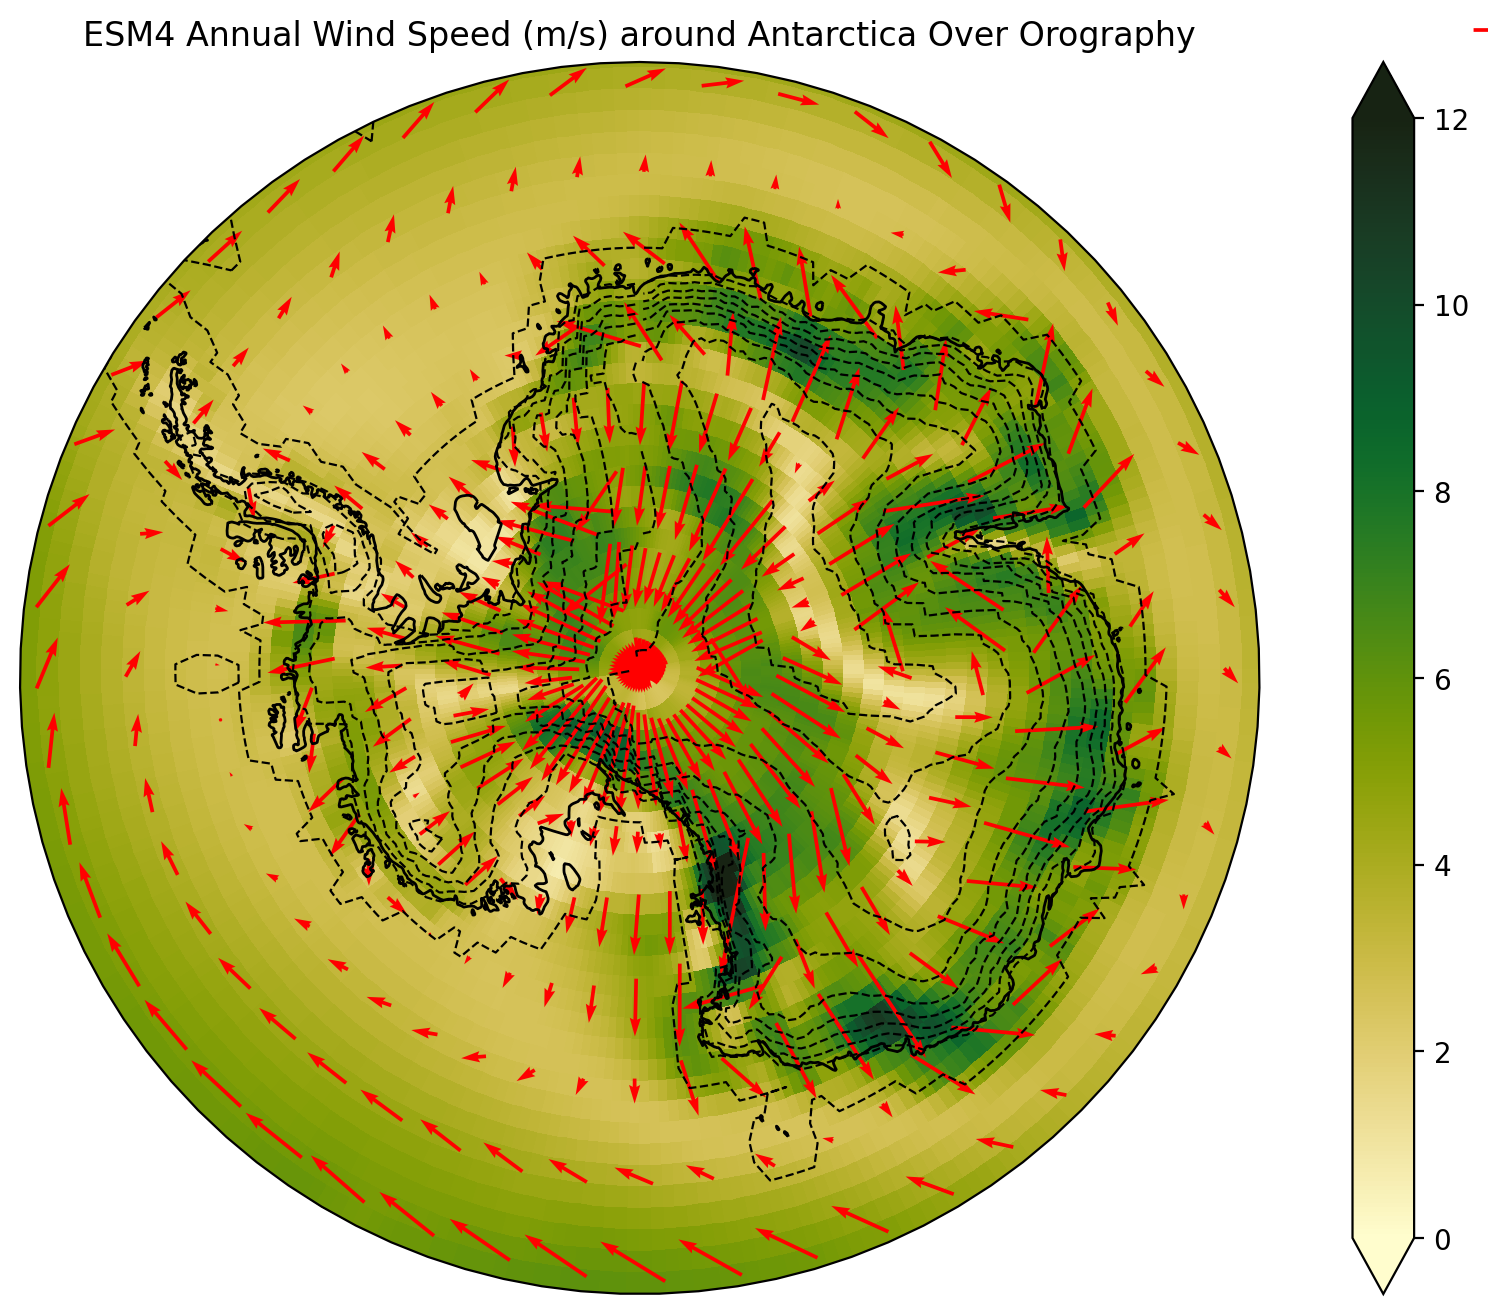

In [34]:
subplot_kws = dict(projection=ccrs.SouthPolarStereo())
fig, ax = plt.subplots(figsize=[12, 8],subplot_kw=subplot_kws)
speedslice.plot(ax=ax,
               transform =ccrs.PlateCarree(),
               vmin=0,
               vmax=12,
               extend='both',
               cmap=cmocean.cm.speed)
ESM4_orog_antslice.plot.contour(ax=ax,
               transform =ccrs.PlateCarree(),
               vmin=0,
               vmax=3600,
               extend='both',
               colors='k', levels=10, linewidths=0.8,linestyles='--')
    # Limit the map to -50 degrees latitude and below.
ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
ax.coastlines()

esm4_timeaveragemerge.isel(longitude=slice(None, None, 6),latitude=slice(0, 36,4)).plot.quiver(x='longitude',
                                       y='latitude',
                                       u='uas',
                                       v='vas',
                                       width=0.003,
                                       scale=98, color='red',transform =ccrs.PlateCarree())
plt.title('ESM4 Annual Wind Speed (m/s) around Antarctica Over Orography')